In [1]:
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

try:
    from transformers import AutoTokenizer
except ImportError:
    import sys
    !{sys.executable} -m pip install transformers
    from transformers import AutoTokenizer

try:
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
except ImportError:
    import sys
    !{sys.executable} -m pip install statsmodels
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor

from huggingface_hub import hf_hub_download

os.makedirs("split", exist_ok=True)
print("⬇ Downloading Parquet files from Hugging Face")
train_file = hf_hub_download(repo_id="dair-ai/emotion", filename="split/train-00000-of-00001.parquet", repo_type="dataset", local_dir="split")
test_file = hf_hub_download(repo_id="dair-ai/emotion", filename="split/test-00000-of-00001.parquet", repo_type="dataset", local_dir="split")
val_file = hf_hub_download(repo_id="dair-ai/emotion", filename="split/validation-00000-of-00001.parquet", repo_type="dataset", local_dir="split")

print("Renaming files")
if not os.path.exists("train.parquet"): os.rename(train_file, "train.parquet")
if not os.path.exists("test.parquet"): os.rename(test_file, "test.parquet")
if not os.path.exists("validation.parquet"): os.rename(val_file, "validation.parquet")

print("Data preparation complete.")

os.makedirs("tokenizer", exist_ok=True)
print("Downloading tokenizer files")
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
tokenizer.save_pretrained("tokenizer")
print("Tokenizer saved in 'tokenizer/'")

c:\Users\dongx\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⬇ Downloading Parquet files from Hugging Face
Renaming files
Data preparation complete.
Tokenizer saved in 'tokenizer/'


In [2]:

sns.set(style="whitegrid")

train_df = pd.read_parquet("train.parquet")
val_df = pd.read_parquet("validation.parquet")
test_df = pd.read_parquet("test.parquet")

df = pd.concat([train_df, val_df, test_df], ignore_index=True)

print("Dataset Overview:")
print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMissing Value Count:\n", df.isnull().sum())
print(" Descriptive Statistics (Numeric Columns):")
print(df.describe(include=['int64', 'float64']))

print("Descriptive Statistics (Text Columns):")
print(df.describe(include=['object']))


Dataset Overview:
Rows: 20,000 | Columns: 2

Columns: ['text', 'label']

Data Types:
 text     object
label     int64
dtype: object

Missing Value Count:
 text     0
label    0
dtype: int64
 Descriptive Statistics (Numeric Columns):
              label
count  20000.000000
mean       1.562850
std        1.496684
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max        5.000000
Descriptive Statistics (Text Columns):
                                                     text
count                                               20000
unique                                              19948
top     i have chose for myself that makes me feel ama...
freq                                                    2


In [3]:

df["text_length"] = df["text"].apply(len)
length_stats = df["text_length"].describe()
missing = df.isnull().sum()

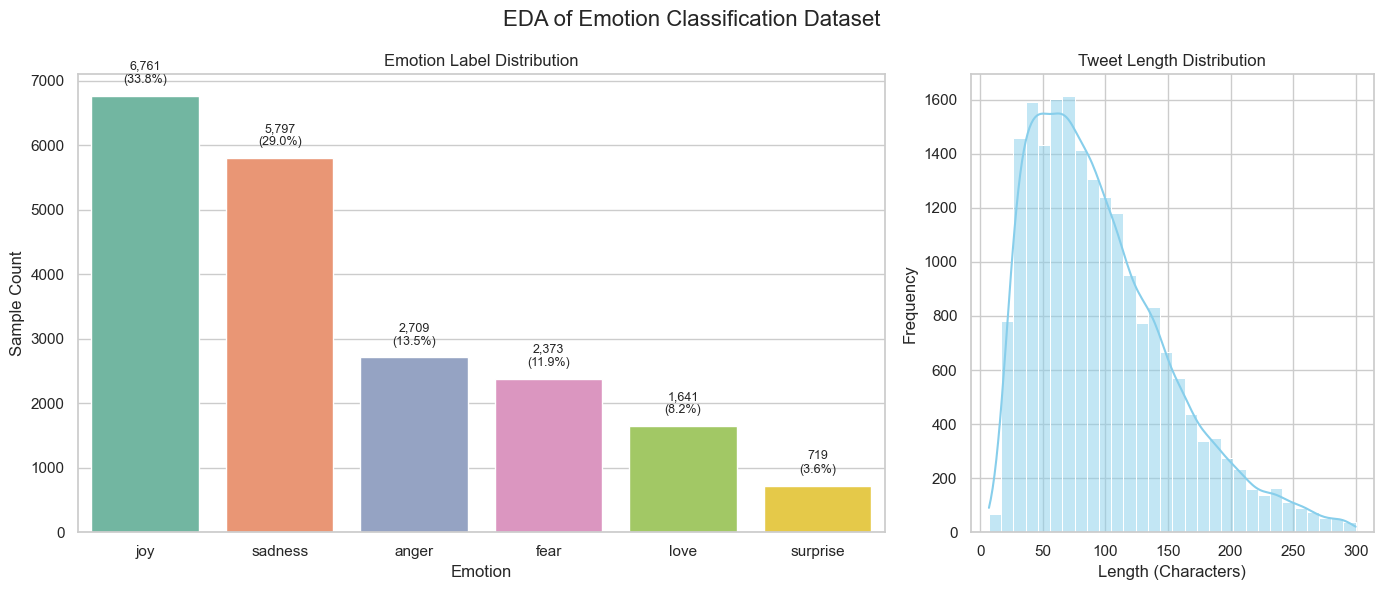

In [4]:
#graph
label2int = {
    "sadness": 0,
    "joy": 1,
    "love": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5
}
int2label = {v: k for k, v in label2int.items()}
df["emotion"] = df["label"].map(int2label)
label_counts = df["emotion"].value_counts().sort_values(ascending=False)
imbalance_ratio = label_counts.max() / label_counts.min()

fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

# 
ax0 = plt.subplot(gs[0])
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2", ax=ax0)
ax0.set_title("Emotion Label Distribution")
ax0.set_ylabel("Sample Count")
ax0.set_xlabel("Emotion")
total = label_counts.sum()
for i, count in enumerate(label_counts.values):
    percent = count / total * 100
    ax0.text(i, count + 200, f"{count:,}\n({percent:.1f}%)", ha="center", fontsize=9)

ax1 = plt.subplot(gs[1])
sns.histplot(df["text_length"], bins=30, kde=True, color="skyblue", ax=ax1)
ax1.set_title("Tweet Length Distribution")
ax1.set_xlabel("Length (Characters)")
ax1.set_ylabel("Frequency")

plt.suptitle("EDA of Emotion Classification Dataset", fontsize=16)
plt.tight_layout()
plt.show()




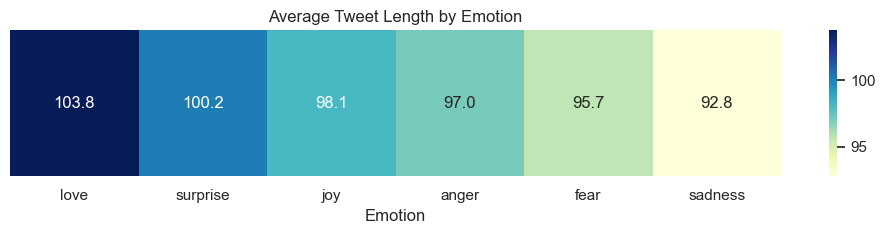

In [5]:
#Heatmap of Emotion ＆Avg Text Length

if "text_length" not in df.columns:
    df["text_length"] = df["text"].apply(len)
if "emotion" not in df.columns:
    label2int = {
        "sadness": 0,
        "joy": 1,
        "love": 2,
        "anger": 3,
        "fear": 4,
        "surprise": 5
    }
    int2label = {v: k for k, v in label2int.items()}
    df["emotion"] = df["label"].map(int2label)


avg_length_per_emotion = df.groupby("emotion")["text_length"].mean().sort_values(ascending=False)


plt.figure(figsize=(10, 2.5))
sns.heatmap(avg_length_per_emotion.to_frame().T, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Tweet Length by Emotion")
plt.yticks([]) 
plt.xlabel("Emotion")
plt.tight_layout()
plt.show()


In [6]:
#Emotion Class Counts
print("\nEmotion Class Counts:\n", label_counts)
print(f"\nClass Imbalance Ratio (Max/Min): {imbalance_ratio:.2f}x")
print("\nText Length Stats:\n", length_stats)
print("\nMissing Values:\n", missing)



Emotion Class Counts:
 emotion
joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: count, dtype: int64

Class Imbalance Ratio (Max/Min): 9.40x

Text Length Stats:
 count    20000.000000
mean        96.670050
std         55.777923
min          7.000000
25%         53.000000
50%         86.000000
75%        129.000000
max        300.000000
Name: text_length, dtype: float64

Missing Values:
 text           0
label          0
text_length    0
dtype: int64


In [7]:
#VIF
print("\nVIF (Variance Inflation Factor) Analysis:")
vif_df = df.select_dtypes(include=['float64', 'int64']).drop(columns=["label"], errors='ignore').copy()
vif_df = vif_df.fillna(vif_df.median())
vif_df = sm.add_constant(vif_df)

vif_result = pd.DataFrame({
    'Feature': vif_df.columns,
    'VIF': [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]
})

print(vif_result.sort_values("VIF", ascending=False))


VIF (Variance Inflation Factor) Analysis:
       Feature       VIF
0        const  4.003869
1  text_length  1.000000


In [8]:
#Data Leakage
print("Checking for Potential Data Leakage:")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

X = df[["text_length"]]
y = df["label"]
model = LogisticRegression(max_iter=1000)
scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")

print(f"Cross-validated accuracy using only text length as feature: {scores.mean():.4f}")
if scores.mean() > 0.8:
    print("High predictive power from a non-textual field (text_length). Potential leakage risk.")
else:
    print("No significant leakage detected from text_length.")

Checking for Potential Data Leakage:
Cross-validated accuracy using only text length as feature: 0.3380
No significant leakage detected from text_length.
